In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls 'drive/MyDrive/Spotify feature classification/Code/Data and Weights'

 2DSpec_wBest1.hdf5	        CSE190_proj_data.ipynb
 2DSpec_wBest.hdf5	       'CSE190_spectrogram data.ipynb'
 2DSpec_wCurrent1.h5	        JaarSongs
 2DSpec_wCurrent.h5	        L_array_44100.pkl
 2DSpec_wCurrent_noDropout.h5   mono_mfcc_normedz_44100.pkl
 3DSpec_wBest.hdf5	        MS_mfcc_normedz_44100.pkl
 3DSpec_wCurrent1.h5	        X_array_22050.pkl
 3DSpec_wCurrent.h5


In [ ]:
import shutil

file_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/MS_mfcc_normedz_44100.pkl'
destination_path = '../content/sample_data/'
shutil.copyfile(file_path, destination_path + 'MS_mfcc_normedz_44100.pkl')

file_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/L_array_44100.pkl'
destination_path = '../content/sample_data/'
shutil.copyfile(file_path, destination_path + 'L_array_44100.pkl')

'../content/sample_data/L_array_44100.pkl'

In [ ]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from numpy.random import choice
from collections import OrderedDict

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Flatten, Concatenate, Activation, Lambda
from keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adam
# from keras.layers import LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)

2.12.0


In [ ]:
with open('sample_data/MS_mfcc_normedz_44100.pkl', 'rb') as file:
    X = pickle.load(file)
with open('sample_data/L_array_44100.pkl', 'rb') as file:
    labels = pickle.load(file)

X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=74)
# X = np.transpose(X, (0,2,3,1))
X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((520, 24, 2584, 2), (130, 24, 2584, 2), (520,), (130,))

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Convolutional network definition
#### Notably, the output is not a classifier and instead a numeric value

In [ ]:
### 2D SPECTROGRAM PARALLEL CONVOLUTION MODEL

def create_model_2D_MFCC(resize_shape):
    # resize_shape = 24, 2584, 2
    # factors are 2,2,2,3 and 2,2,2,17,19
    # Mid and side inputs
    input_MS = Input(shape = resize_shape)

    # Convolutional layers for sequence 1
    conv = Conv2D(64, (3, 4), activation='relu', padding='same', kernel_initializer='he_normal')(input_MS)
    conv = Conv2D(64, (3, 4), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = Conv2D(128, (3, 4), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = Conv2D(128, (3, 4), activation='relu', kernel_initializer='he_normal')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = MaxPooling2D(2, 2)(conv)
    conv = Conv2D(256, (3, 4), activation='relu', kernel_initializer='he_normal')(conv)
    conv = Conv2D(256, (3, 4), activation='relu', kernel_initializer='he_normal')(conv)
    conv = Dropout(0.3)(conv)
    conv = BatchNorm()(conv)
    conv = Conv2D(512, (3, 4), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = BatchNorm()(conv)
    conv = MaxPooling2D(2, 2)(conv)
    conv = Flatten()(conv)
    conv = Dropout(0.3)(conv)

    # Fully connected -> output
    combined = Dense(256, activation='relu')(conv)
    combined = BatchNorm()(combined)
    combined = Dense(64)(combined)
    combined = Dropout(0.3)(combined)
    combined = BatchNorm()(combined)
    combined = Dense(16, activation='relu')(combined)
    combined = BatchNorm()(combined)
    prediction = Dense(1, activation='sigmoid')(combined)

    # Create the model with two inputs and one output
    model = Model(inputs=input_MS, outputs=prediction)

    return model

# Create model
# Shape is one (24, 2584) or one 30 sec window split into 200 windows
# factors are 2,2,2,3 and 2,2,2,17,19
model_2D_spec = create_model_2D_MFCC((24, 2584, 2))

# Compile the model for regression
opt = Adam(learning_rate=0.01)
model_2D_spec.compile(optimizer=opt, loss='mean_absolute_error', metrics=['mean_absolute_error'])

# Print a summary of the model architecture
model_2D_spec.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 2584, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 24, 2584, 64)      1600      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 2584, 64)      49216     
                                                                 
 dropout (Dropout)           (None, 24, 2584, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 24, 2584, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 2584, 128)     98432     
                                                             

# Train the model

In [ ]:
# X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((520, 2, 24, 2584), (130, 2, 24, 2584), (520,), (130,))

def train_network(model):
    checkpoint = ModelCheckpoint(
        "2DSpec_wBest.hdf5",
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )

    callbacks_list = [checkpoint]
    # early_stopping = EarlyStopping(monitor='val_loss', patience=50, mode='min', verbose=1)

    hist = model.fit(x=X_train, y=y_train, batch_size=4, epochs=150, shuffle=True, validation_data = (X_test, y_test), callbacks = callbacks_list)
    model.save_weights('drive/MyDrive/Spotify feature classification/Code/Data and Weights/2DSpec_wCurrent.h5')
    model.save_weights('2DSpec_wCurrent.h5')

    file_path = '2DSpec_wBest.hdf5'
    destination_path = 'drive/MyDrive/Spotify feature classification/Code/Data and Weights/'
    shutil.copyfile(file_path, destination_path + '2DSpec_wBest.hdf5')

    return hist

history = train_network(model_2D_spec)

Epoch 1/150
130/130 [==============================] - ETA: 0s - loss: 0.2051 - mean_absolute_error: 0.2051
Epoch 1: val_loss improved from inf to 0.36454, saving model to 2DSpec_wBest.hdf5
130/130 [==============================] - 61s 397ms/step - loss: 0.2051 - mean_absolute_error: 0.2051 - val_loss: 0.3645 - val_mean_absolute_error: 0.3645
Epoch 2/150
130/130 [==============================] - ETA: 0s - loss: 0.1778 - mean_absolute_error: 0.1778
Epoch 2: val_loss improved from 0.36454 to 0.19669, saving model to 2DSpec_wBest.hdf5
130/130 [==============================] - 52s 404ms/step - loss: 0.1778 - mean_absolute_error: 0.1778 - val_loss: 0.1967 - val_mean_absolute_error: 0.1967
Epoch 3/150
130/130 [==============================] - ETA: 0s - loss: 0.1805 - mean_absolute_error: 0.1805
Epoch 3: val_loss did not improve from 0.19669
130/130 [==============================] - 19s 146ms/step - loss: 0.1805 - mean_absolute_error: 0.1805 - val_loss: 0.3055 - val_mean_absolute_error: 

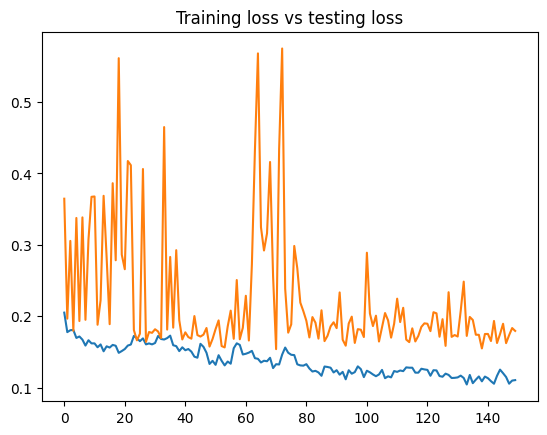

In [ ]:
plt.title("Training loss vs testing loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

Serious variation in validation loss can be seen thoughout training, and while there is somewhat of a taming effect, it appears to be uncalibrated.

# Test the model and plot results
Accuracy is measured in mean error, standard deviation, and correlation

In [ ]:
model_2D_spec = create_model_2D_MFCC((24, 2584, 2))
model_2D_spec.load_weights('drive/MyDrive/Spotify feature classification/Code/Data and Weights/2DSpec_wCurrent.h5')

def correlation_coefficient(X, Y):
    # Check if both arrays have the same length
    if len(X) != len(Y):
        raise ValueError("Both arrays must have the same length.")

    n = len(X)

    # Calculate the means of both arrays
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)

    # Calculate the numerator of the correlation coefficient
    numerator = np.sum((X - mean_X) * (Y - mean_Y))

    # Calculate the denominator of the correlation coefficient
    denominator = np.sqrt(np.sum((X - mean_X)**2) * np.sum((Y - mean_Y)**2))

    # Calculate the correlation coefficient (r)
    r = numerator / denominator

    return r

In [ ]:
### MEAN ERRORS of train and test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_pred = model_2D_spec.predict(X_train[:])
test_pred = model_2D_spec.predict(X_test[:])

train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))

train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)

print()
### Chance to be significantly off
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train))
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test))
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 1s 192ms/step
Average training error (absolute): 0.1170647562415783
Average testing error (absolute): 0.17952480562485182

Standard deviation of train error: 0.2516145736680124
Standard deviation of test error: 0.32396264517964907
Average training error (square): 0.020773771802807185
Average testing error (square): 0.047514673412169806

0.1576923076923077
0.4153846153846154

Correlation coefficient train: 0.8105989562934673
Correlation coefficient test: 0.2715469331648932


### As we look at the correlation of the fully fit model, we see that the testing predictions are actually significantly less correlated than the training.

It seems like we have an overfitting issue.  In that case, lets try adding some dropout!  I'll also try adding a layer at 64 and 128

## Let's check our most accurate testing iteration

In [ ]:
model_2D_spec.load_weights("drive/MyDrive/Spotify feature classification/Code/Data and Weights/2DSpec_wBest.hdf5")

### MEAN ERRORS of train and test
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

train_pred = model_2D_spec.predict(X_train[:])
test_pred = model_2D_spec.predict(X_test[:])
print()
train_error = np.sum(np.abs(train_pred - y_train))/len(y_train)
test_error = np.sum(np.abs(test_pred - y_test))/len(y_test)
print("Average training error (absolute):", train_error)
print("Average testing error (absolute):", test_error)
print()
print("Standard deviation of train error:", np.sqrt(np.sum(np.abs(np.abs(train_pred - y_train)-train_error))/len(y_train)))
print("Standard deviation of test error:", np.sqrt(np.sum(np.abs(np.abs(test_pred - y_test)-test_error))/len(y_test)))

train_error = np.sum(np.square(train_pred - y_train))/len(y_train)
test_error = np.sum(np.square(test_pred - y_test))/len(y_test)
print("Average training error (square):", train_error)
print("Average testing error (square):", test_error)

print()
print(len(y_train[np.abs(train_pred - y_train) > 0.2]) / len(y_train), "% training are significantly off.")
print(len(y_test[np.abs(test_pred - y_test) > 0.2]) / len(y_test), "% testing are significantly off.")
print()
result = correlation_coefficient(train_pred, y_train.reshape(-1, 1))
print("Correlation coefficient train:", result)
result = correlation_coefficient(test_pred, y_test.reshape(-1, 1))
print("Correlation coefficient test:", result)

5/5 [==============================] - 1s 190ms/step

Average training error (absolute): 0.11683412769932014
Average testing error (absolute): 0.15402635269733575

Standard deviation of train error: 0.2833553159283039
Standard deviation of test error: 0.3346633127925176
Average training error (square): 0.023229922773968986
Average testing error (square): 0.040930798506728164

0.21346153846153845 % training are significantly off.
0.3384615384615385 % testing are significantly off.

Correlation coefficient train: 0.6833577808183664
Correlation coefficient test: 0.3463623757422866


### The train and test results are for more consistent here, but it can be seen that the effect size is also significantly reduced.